<a id='start'></a>
# Проект Мастерская №1

## Цель проекта
Отработать навыки работы с реальными данными.  
В качестве примера приведены данные о стартапах, функционировавших с 1980 по 2018 годы.  
Необходимо разработать модель машинного обучения при предсказания продолжения работы стартапа.  
Провести все необхрдимые работы с исходными датасетами и дать рекомендации создателям стартапов.

### Задачи для 1 части проекта:
* [Изучить и подготовить данные](#download)
* [Провести предобработку данных](#preprocessing)
* [Провести исследователький анализ данных](#research)
* [Провести корреляционный анализ данных](#corr)

### Задачи для 2 части проекта:
* [Разработать модели для предсказания статуса стартапов](#models)

<a id='download'></a>
## [Загрузка данных](#start)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    RobustScaler
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
# Задаем необходимые константы
RANDOM_STATE = 42

In [3]:
# Загружаем тренировочную выборку
startups_train = pd.read_csv(
    'datasets/kaggle_startups_train_28062024.csv'
)
# Просматриваем первичную информацию о датасете
startups_train.info()
# Просматриваем первые 5 строк датасета
startups_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [4]:
# Загружаем тестовую выборку
startups_test = pd.read_csv(
    'datasets/kaggle_startups_test_28062024.csv'
)
# Просматриваем первичную информацию о датасете
startups_test.info()
# Просматриваем первые 5 строк датасета
startups_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [5]:
# Загружаем информацию о статусе стартапа
startups_status = pd.read_csv(
    'datasets/kaggle_startups_sample_submit_28062024.csv'
)
# Просматриваем первичную информацию о датасете
startups_status.info()
# Просматриваем первые 5 строк датасета
startups_status.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [6]:
# Объединяем датасет с тестовыми данными с датасетом с входными признаками для дальнейшей работы
startups_test = startups_test.merge(startups_status, on='name')

**Можно заметить, что в тестовой выборке нет параметров стартапа 'founded_at' и 'closed_at'. В ней они заменены параметром lifetime который является количеством дней от старта до закрытия стартапа.**

In [7]:
# Переведем дату основания фирм в формат даты
startups_train['founded_at'] = pd.to_datetime(
    startups_train['founded_at'], format='%Y-%m-%d'
)
# Не закрытые фирмы не имеют даты закрытия, поэтоу для расчета lifetime укажем им дату закрытия как текующую дату
startups_train['closed_at'] = startups_train['closed_at'].fillna('2024-11-02')
# Переведем дату закрытия фирм в формат даты
startups_train['closed_at'] = pd.to_datetime(
    startups_train['closed_at'], format='%Y-%m-%d'
)

In [8]:
# Создаем параметр lifetime
startups_train['lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days
# Проверяем полученный результат
startups_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2024-11-02,5495
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2024-11-02,7245
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2024-11-02,6880
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2024-11-02,7611
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2024-11-02,5288


In [9]:
# Удаляем столбцы с датой основания и закрытия
startups_train = startups_train.drop(['founded_at', 'closed_at'], axis=1)

In [10]:
# Сравниваем первичную информацию о тренировочном и тестовом датасетах
startups_train.info()
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   first_funding_at   52516 non-null  object 
 10  last_funding_at    52516 non-null  object 
 11  lifetime           52516 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  


**Промежуточный вывод:** 
* Судя по первичной информации о датасетах  - имеются пропуски в тренировочных данных и во входных данных тестовой выборки.    
* Наименования столбцов  соответствуют змеинному регистру  
* Все типы колонок соответствуют их содержимому
* Тренировочный и тестовый датасеты приведны к одинаковому содержанию для моделирования, на основе старых признаком создан в тренировочном датасете создан признак 'lifetime'

<a id='preprocessing'></a>
## [Предобработка данных](#start)

In [11]:
# Проверим датасет 'startups_train' на наличие явных дубликатов
print(
    'Явных дубликатов в "startups_train" -',
    startups_train.duplicated().sum()
)

Явных дубликатов в "startups_train" - 0


In [12]:
# Проверим датасет 'startups_test' на наличие явных дубликатов
print(
    'Явных дубликатов в "startups_test" -',
    startups_test.duplicated().sum()
)

Явных дубликатов в "startups_test" - 0


In [13]:
# Проверим датасет 'startups_train' на наличие пропусков
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
first_funding_at         0
last_funding_at          0
lifetime                 0
dtype: int64

In [14]:
# Создаем объекты для заполнения попусков
# в категориальных колонках по модам
cat_imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='most_frequent'
) 
# в в числовых колонках по медианам
num_imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='median'
) 

In [15]:
# Создаем список категориальных признаков
cat_col_names = (
    startups_train
    .select_dtypes(exclude='number')
    .columns.tolist()
)
# Смотрим список
cat_col_names

['name',
 'category_list',
 'status',
 'country_code',
 'state_code',
 'region',
 'city',
 'first_funding_at',
 'last_funding_at']

In [16]:
# Создаем список количественных признаков
num_col_names = (
    startups_train
    .select_dtypes(include='number')
    .columns.tolist()
)
# Смотрим список
num_col_names

['funding_total_usd', 'funding_rounds', 'lifetime']

In [17]:
# Обучаем импьютер для категориальных колонок
cat_imputer.fit(startups_train[cat_col_names])

SimpleImputer(strategy='most_frequent')

In [18]:
# Заполняем пропуски в категориальных колонках
startups_train[cat_imputer.feature_names_in_] = cat_imputer.transform(startups_train[cat_col_names])

In [19]:
# Обучаем импьютер для числовых колонок
num_imputer.fit(startups_train[num_col_names])

SimpleImputer(strategy='median')

In [20]:
# Заполняем пропуски в числовых колонках
startups_train[num_imputer.feature_names_in_] = num_imputer.transform(startups_train[num_col_names])

In [21]:
# Проверяем результат
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  52516 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  float64
 9   first_funding_at   52516 non-null  object 
 10  last_funding_at    52516 non-null  object 
 11  lifetime           52516 non-null  float64
dtypes: float64(3), object(9)
memory usage: 4.8+ MB


In [22]:
# Проверим датасет 'startups_test' на наличие пропусков
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
status                  0
dtype: int64

In [23]:
# Заполняем пропуски в категориальных колонках
startups_test[cat_imputer.feature_names_in_] = cat_imputer.transform(startups_test[cat_col_names])

In [24]:
# Заполняем пропуски в числовых колонках
startups_test[num_imputer.feature_names_in_] = num_imputer.transform(startups_test[num_col_names])

In [25]:
# Проверяем результат
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  float64
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  float64
 11  status             13125 non-null  object 
dtypes: float64(3), object(9)
memory usage: 1.3+ MB


**Промежуточный вывод:** 
* Датасеты проверены на наличие явных дубликатов.
* Обнаруженные пропуски устранены

<a id='research'></a>
## [Исследовательский анализ данных](#start)

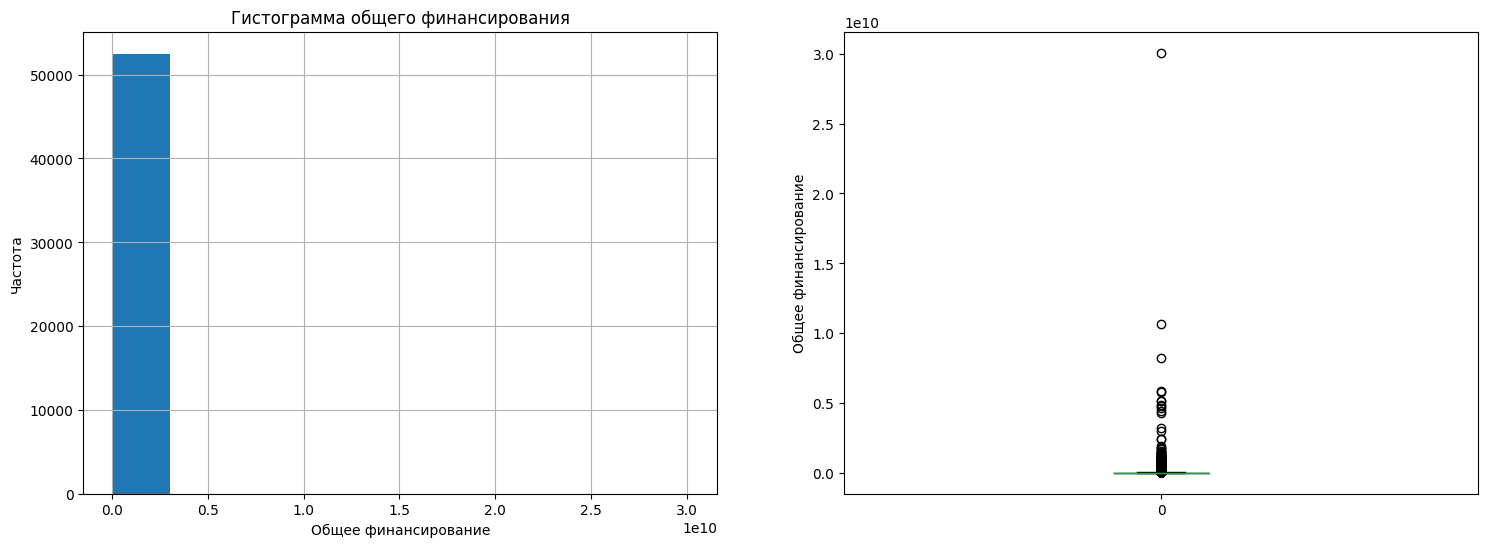

count    5.251600e+04
mean     1.513232e+07
std      1.683466e+08
min      1.000000e+00
25%      5.297212e+05
50%      2.000000e+06
75%      6.788929e+06
max      3.007950e+10
Name: funding_total_usd, dtype: float64

In [26]:
# Строим гистограмму для общего финансирования и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train[
    'funding_total_usd'].hist(figsize=(18, 6))
plt.title('Гистограмма общего финансирования')
plt.xlabel('Общее финансирование')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_total_usd'
].plot.box(use_index=False)
plt.ylabel('Общее финансирование')
plt.show()
startups_train[
    'funding_total_usd'
].describe()

In [27]:
# Считаем количество компаний с общим финансированием меньше 1000 долларов
print(
    'Количество компаний с общим финансированием меньше 1000 долларов -',
    startups_train[
        'funding_total_usd'
    ].loc[
        startups_train['funding_total_usd'] < 1000
    ].count()
)

Количество компаний с общим финансированием меньше 1000 долларов - 48


In [28]:
# Считаем количество компаний с общим финансированием больше 10.000.000 долларов
print(
    'Количество компаний с общим финансированием больше 10.000.000 долларов -',
    startups_train[
    'funding_total_usd'
    ].loc[
        startups_train['funding_total_usd'] > 100000000
    ].count()
)

Количество компаний с общим финансированием больше 10.000.000 долларов - 1238


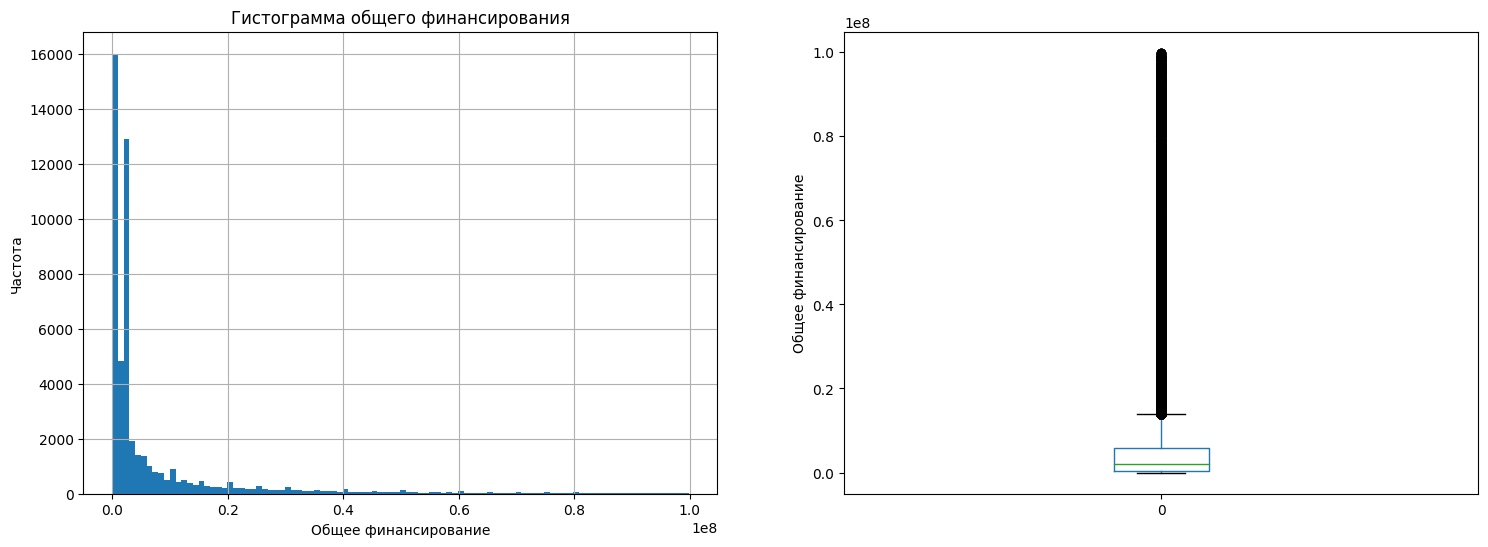

count    5.111400e+04
mean     7.349213e+06
std      1.461938e+07
min      1.050000e+03
25%      5.000000e+05
50%      2.000000e+06
75%      5.844952e+06
max      9.980000e+07
Name: funding_total_usd, dtype: float64

In [29]:
# Строим гистограмму для общего финансирования и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000)
].hist(bins=100, figsize=(18, 6))
plt.title('Гистограмма общего финансирования')
plt.xlabel('Общее финансирование')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000)
].plot.box(use_index=False)
plt.ylabel('Общее финансирование')
plt.show()
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000)
].describe()

**Распределение финансирования не соответствует нормальному распределению. Большинство стартапов получают низкое финансирование.**

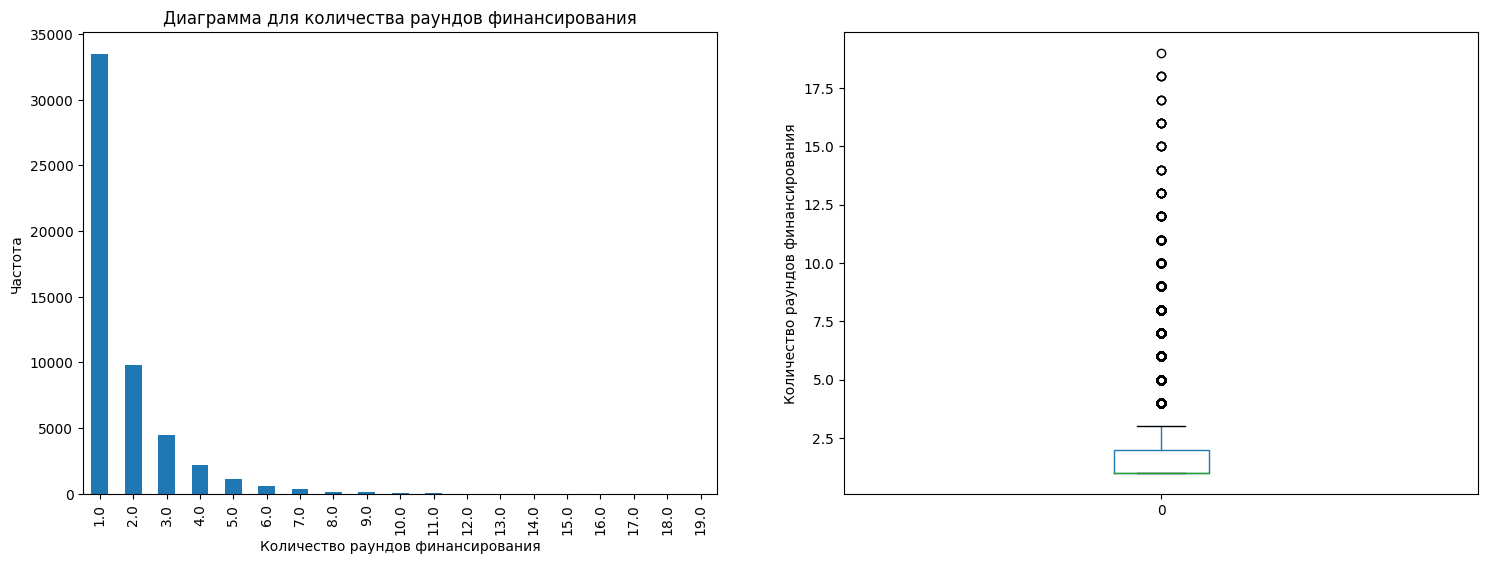

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

In [30]:
# Строим диаграмму для количества раундов финансирования и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
(
    startups_train.groupby(
        'funding_rounds'
    )[
        'funding_rounds'
    ].count().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title(
    'Диаграмма для количества раундов финансирования'
)
plt.xlabel('Количество раундов финансирования')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_rounds'
].plot.box(use_index=False)
plt.ylabel('Количество раундов финансирования')
plt.show()
startups_train[
    'funding_rounds'
].describe()

**Распределение количества раундов финансирования не соответствует нормальному распределению. Большинство стартапов имеют малое количество раундов финансирования. Это коррелирует с низким суммарным финансированием большинства проектов**

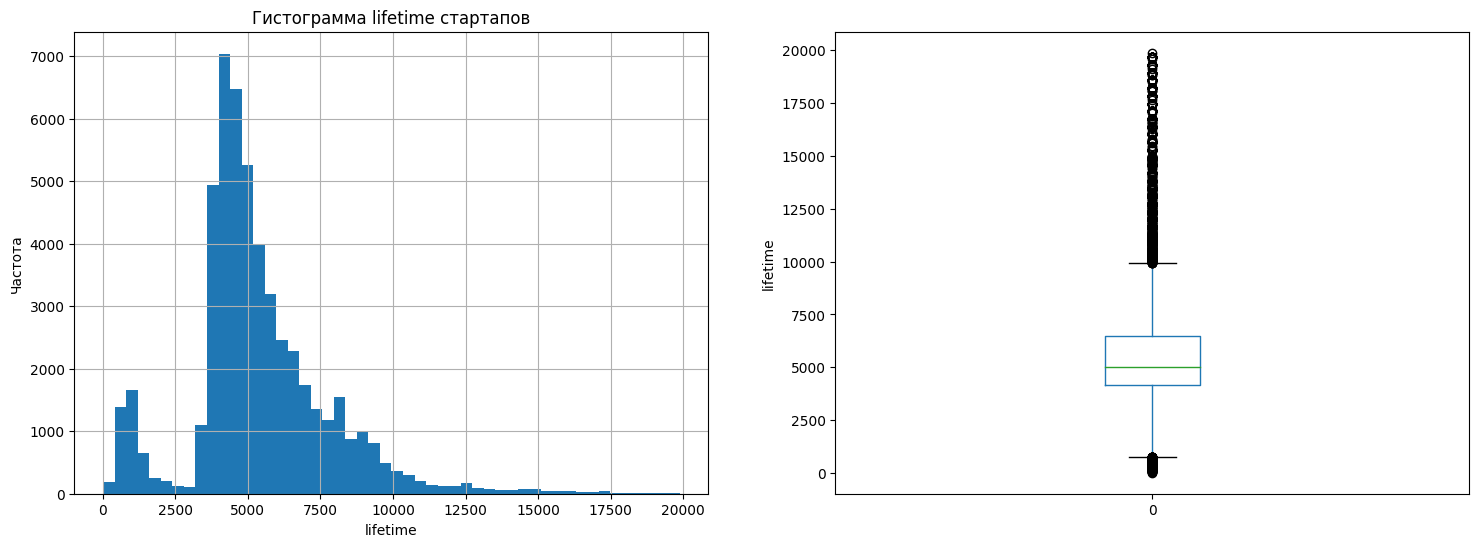

count    52516.000000
mean      5404.037493
std       2440.616197
min         19.000000
25%       4187.000000
50%       5013.000000
75%       6483.250000
max      19875.000000
Name: lifetime, dtype: float64

In [31]:
# Строим гистограмму для lifetime стартапов и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train[
    'lifetime'
].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма lifetime стартапов')
plt.xlabel('lifetime')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'lifetime'
].plot.box(use_index=False)
plt.ylabel('lifetime')
plt.show()
startups_train[
    'lifetime'
].describe()

**Распределение времени жизни стартапов не соответствует нормальному распределению. Наблюдается бимодальность. Есть пик количества стартапов с временем жизни около 1000 дней.**

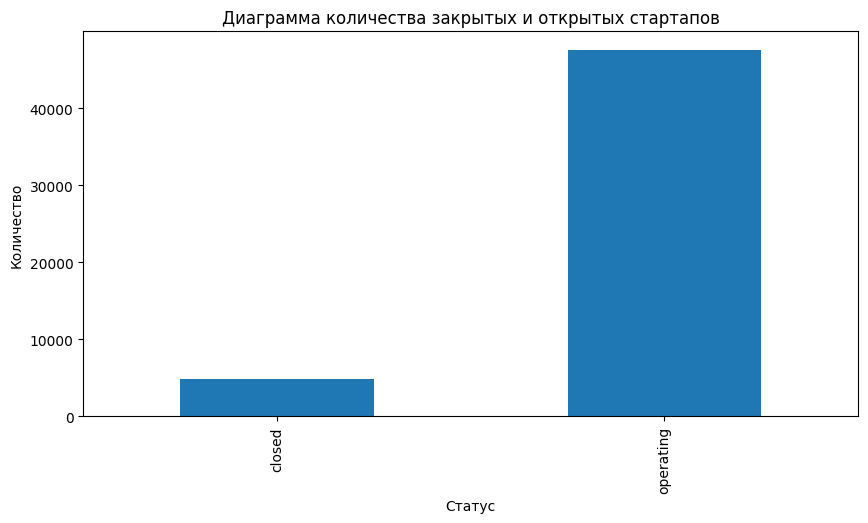

In [32]:
# Cтроим диаграмму количества закрытых и работающих стартапов
(
    startups_train.groupby(
        'status'
    )[
        'funding_rounds'
    ].count().plot(kind='bar', legend=False, figsize=(10, 5))
)
plt.title('Диаграмма количества закрытых и открытых стартапов')
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.show()

**Наблюдается сильный дисбаланс классов в целевом признаке**

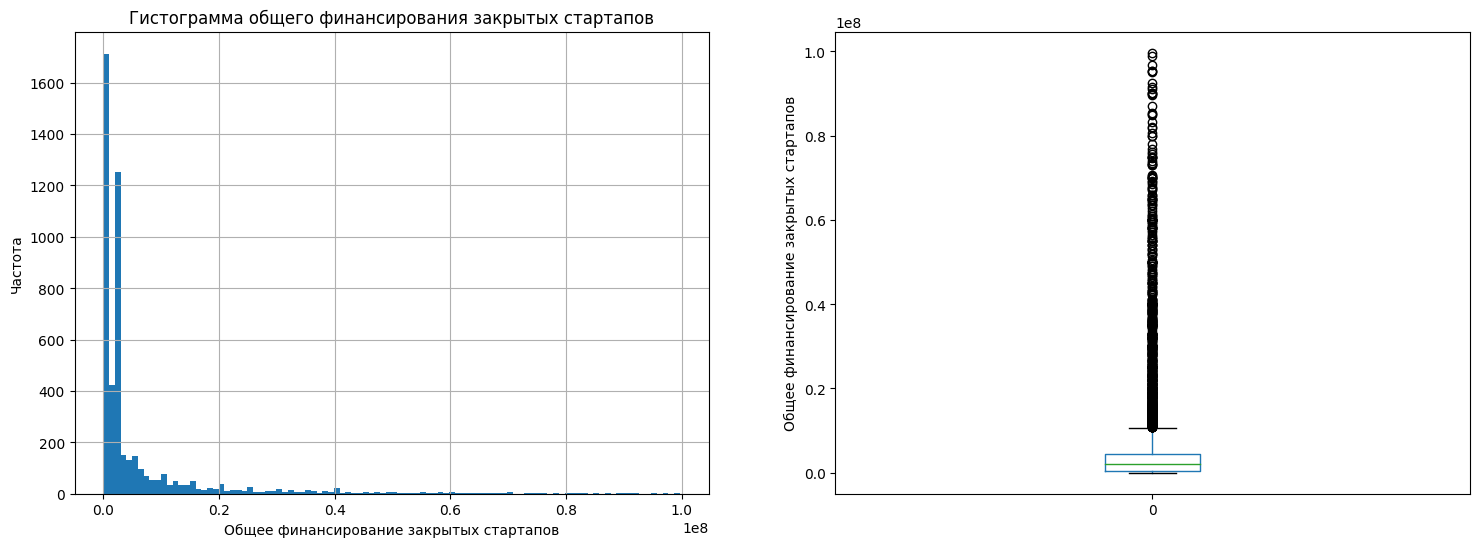

count    4.837000e+03
mean     5.955917e+06
std      1.246648e+07
min      1.100000e+03
25%      3.500000e+05
50%      2.000000e+06
75%      4.500000e+06
max      9.967000e+07
Name: funding_total_usd, dtype: float64

In [33]:
# Строим гистограмму для общего финансирования и boxplot диаграмму закрытых стартапов, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000) &
    (startups_train['status'] == 'closed')
].hist(bins=100, figsize=(18, 6))
plt.title('Гистограмма общего финансирования закрытых стартапов')
plt.xlabel('Общее финансирование закрытых стартапов')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000) &
    (startups_train['status'] == 'closed')
].plot.box(use_index=False)
plt.ylabel('Общее финансирование закрытых стартапов')
plt.show()
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000) &
    (startups_train['status'] == 'closed')
].describe()

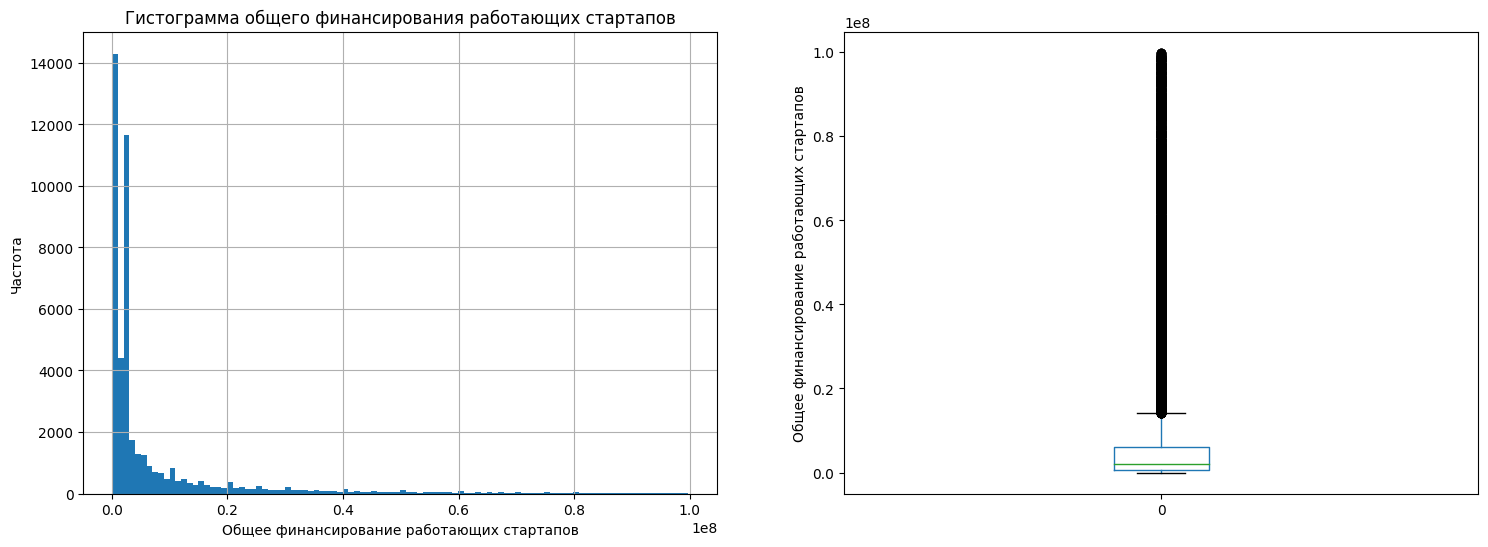

count    4.627700e+04
mean     7.494844e+06
std      1.481893e+07
min      1.050000e+03
25%      5.250000e+05
50%      2.000000e+06
75%      6.000000e+06
max      9.980000e+07
Name: funding_total_usd, dtype: float64

In [34]:
# Строим гистограмму для общего финансирования и boxplot диаграмму работающих стартапов, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000) &
    (startups_train['status'] == 'operating')
].hist(bins=100, figsize=(18, 6))
plt.title('Гистограмма общего финансирования работающих стартапов')
plt.xlabel('Общее финансирование работающих стартапов')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000) &
    (startups_train['status'] == 'operating')
].plot.box(use_index=False)
plt.ylabel('Общее финансирование работающих стартапов')
plt.show()
startups_train[
    'funding_total_usd'
].loc[
    (startups_train['funding_total_usd'] > 1000) &
    (startups_train['funding_total_usd'] < 100000000) &
    (startups_train['status'] == 'operating')
].describe()

**Не наблюдается разницы в гистограммах финансирования закрытых и раюотающих стартаров**

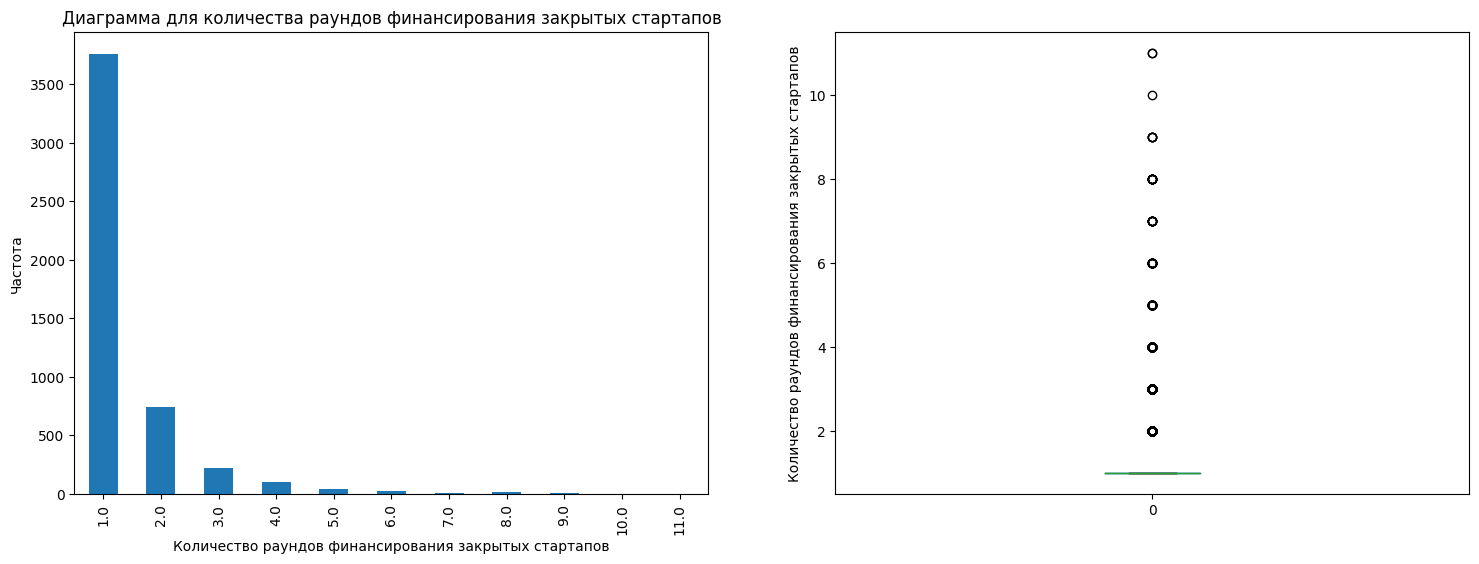

count    4917.000000
mean        1.404312
std         0.962079
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: funding_rounds, dtype: float64

In [35]:
# Строим диаграмму для количества раундов финансирования и boxplot диаграмму закрытых стартапов, также смотрим описание данных
plt.subplot(1, 2, 1)
(
    startups_train.loc[
        startups_train['status'] == 'closed'
    ].groupby(
        'funding_rounds'
    )[
        'funding_rounds'
    ].count().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title(
    'Диаграмма для количества раундов финансирования закрытых стартапов'
)
plt.xlabel('Количество раундов финансирования закрытых стартапов')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train.loc[
        startups_train['status'] == 'closed'
    ][
    'funding_rounds'
].plot.box(use_index=False)
plt.ylabel('Количество раундов финансирования закрытых стартапов')
plt.show()
startups_train.loc[
        startups_train['status'] == 'closed'
    ][
    'funding_rounds'
].describe()

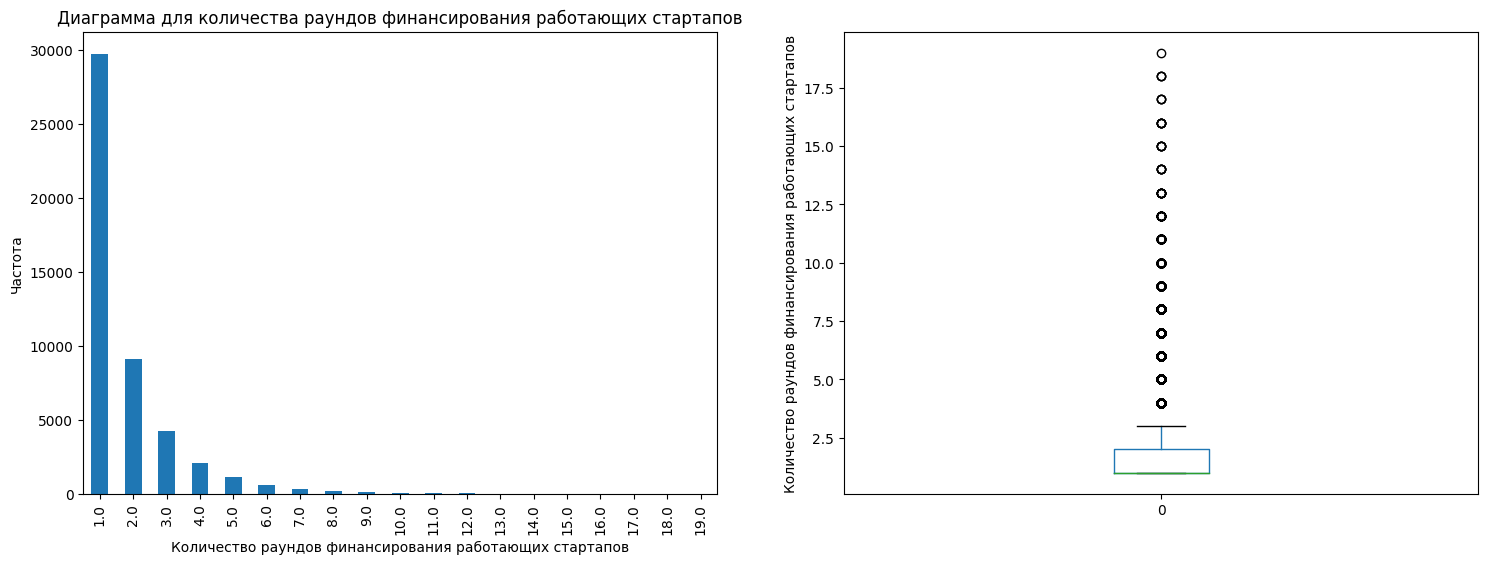

count    47599.000000
mean         1.775415
std          1.405699
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

In [36]:
# Строим диаграмму для количества раундов финансирования и boxplot диаграмму работающих стартапов, также смотрим описание данных
plt.subplot(1, 2, 1)
(
    startups_train.loc[
        startups_train['status'] == 'operating'
    ].groupby(
        'funding_rounds'
    )[
        'funding_rounds'
    ].count().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title(
    'Диаграмма для количества раундов финансирования работающих стартапов'
)
plt.xlabel('Количество раундов финансирования работающих стартапов')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train.loc[
        startups_train['status'] == 'operating'
    ][
    'funding_rounds'
].plot.box(use_index=False)
plt.ylabel('Количество раундов финансирования работающих стартапов')
plt.show()
startups_train.loc[
        startups_train['status'] == 'operating'
    ][
    'funding_rounds'
].describe()

**Можно заметить, что все закрытые стартапы имеют не больше 11 раундов финансирования.**

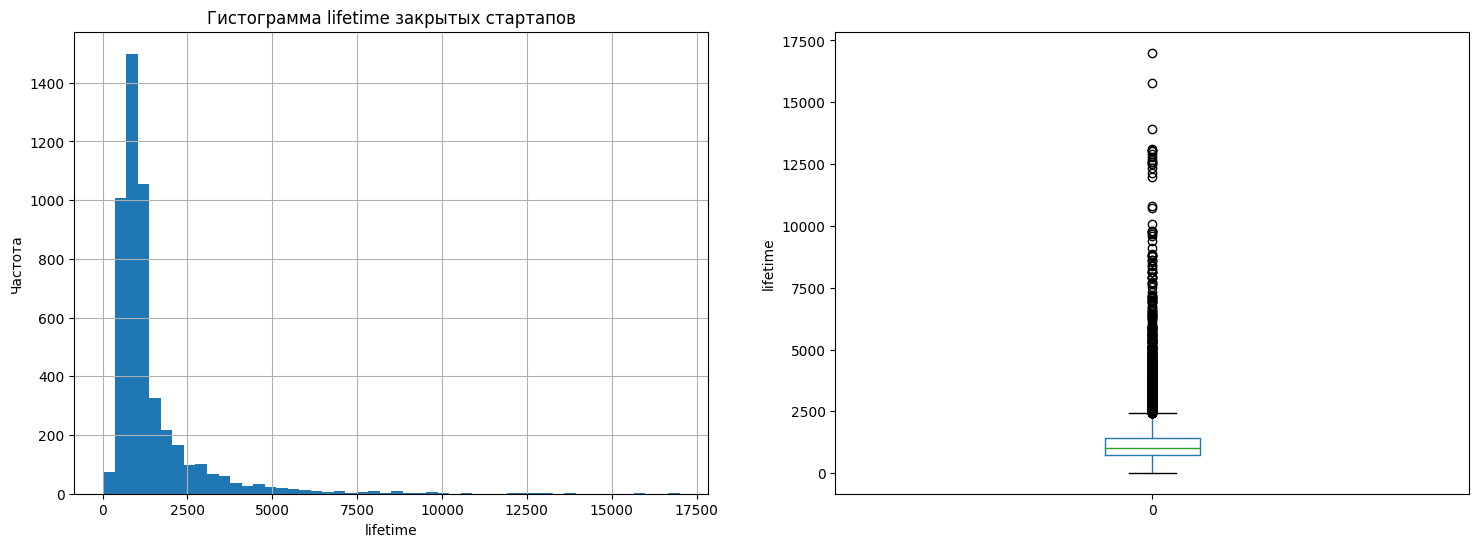

count     4917.000000
mean      1399.249949
std       1378.294089
min         19.000000
25%        735.000000
50%       1013.000000
75%       1407.000000
max      17004.000000
Name: lifetime, dtype: float64

In [37]:
# Строим гистограмму для lifetime закрытых стартапов и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train.loc[
        startups_train['status'] == 'closed'
    ][
    'lifetime'
].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма lifetime закрытых стартапов')
plt.xlabel('lifetime')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train.loc[
        startups_train['status'] == 'closed'
    ][
    'lifetime'
].plot.box(use_index=False)
plt.ylabel('lifetime')
plt.show()
startups_train.loc[
        startups_train['status'] == 'closed'
    ][
    'lifetime'
].describe()

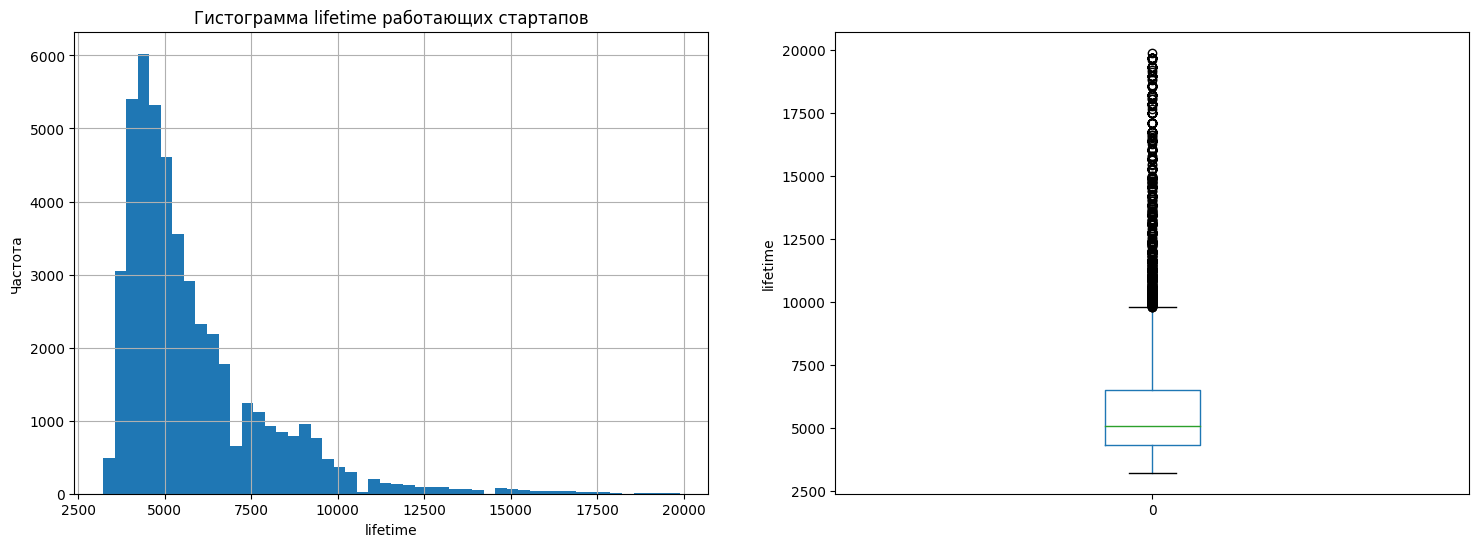

count    47599.000000
mean      5817.734007
std       2132.554188
min       3228.000000
25%       4323.000000
50%       5076.000000
75%       6515.000000
max      19875.000000
Name: lifetime, dtype: float64

In [38]:
# Строим гистограмму для lifetime работающих стартапов и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
startups_train.loc[
        startups_train['status'] == 'operating'
    ][
    'lifetime'
].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма lifetime работающих стартапов')
plt.xlabel('lifetime')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
startups_train.loc[
        startups_train['status'] == 'operating'
    ][
    'lifetime'
].plot.box(use_index=False)
plt.ylabel('lifetime')
plt.show()
startups_train.loc[
        startups_train['status'] == 'operating'
    ][
    'lifetime'
].describe()

**Можно увидеть, что аномальный пик на общей гистограмме lifetime стартапов относится к закрытым стартапам. Пики распределений закрытых и работающих стартапов смещены относительно друг друга.**

**Промежуточный вывод:** 
* Большинство стартаров имеют низкое финансирование, независимо от того были ли они закрыты или работают
* Закрытые стартары всегда имеют не больше 11 раундов финансирования
* На закрытые стартапы приходится отдельный пик в области низкого времени жизни стартапов

<a id='corr'></a>
## [Корреляционный анализ](#start)

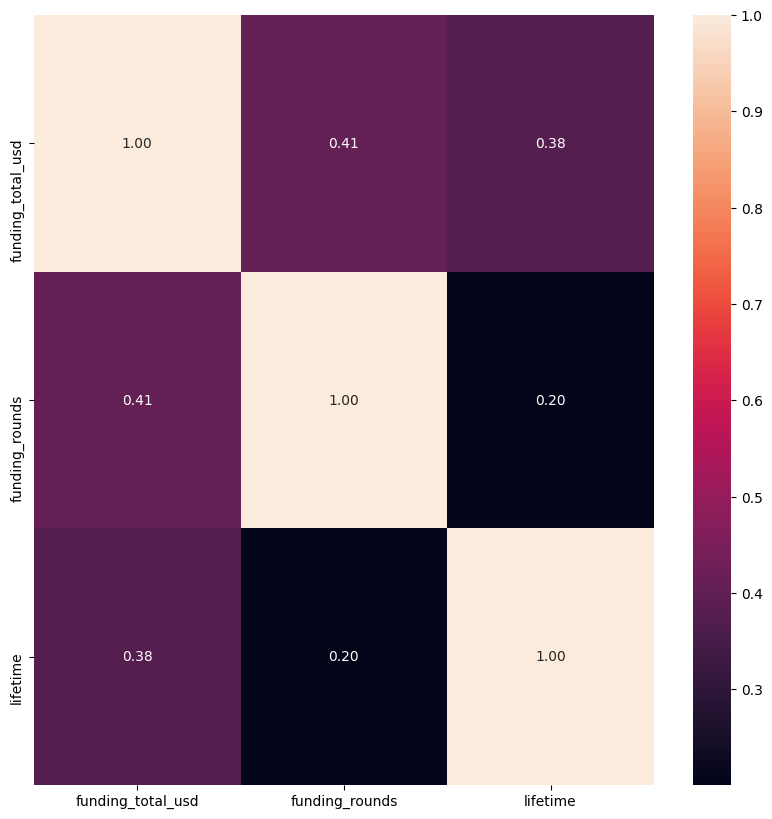

In [39]:
# Строим тепловую карту коэффициентов корреляции Спирмена
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(startups_train.corr(method='spearman'), annot=True, fmt='.2f', ax=ax)
plt.show()

**В матрице нет признаков с коэффициентом корреляции от 0.9 до 0.95 по модулю.  
Можно сделать вывод об отсутствии мультиколлинеарности.**

In [40]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  float64
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  float64
 11  status             13125 non-null  object 
dtypes: float64(3), object(9)
memory usage: 1.3+ MB


In [41]:
# Рассмотрим информацию о параметре 'category_list'
startups_train['category_list'].describe()

count        52516
unique       22105
top       Software
freq          5672
Name: category_list, dtype: object

**В ней 22105 категорий**

In [42]:
def less_categories(category_list):
    if startups_train.loc[startups_train['category_list'] == category_list]['category_list'].count() < 1000:
        return 'Категории с менее чем 1000 стартапов'
    elif 1000 <= startups_train.loc[startups_train['category_list'] == category_list]['category_list'].count() < 2000:
        return 'Категории с от 1000 до 2000 стартапов'
    elif 2000 <= startups_train.loc[startups_train['category_list'] == category_list]['category_list'].count() < 3000:
        return 'Категории с от 2000 до 3000 стартапов'
    elif 3000 <= startups_train.loc[startups_train['category_list'] == category_list]['category_list'].count() < 4000:
        return 'Категории с от 3000 до 4000 стартапов'
    elif 4000 <= startups_train.loc[startups_train['category_list'] == category_list]['category_list'].count() < 5000:
        return 'Категории с от 4000 до 5000 стартапов'
    else:
        return 'Категории с 5000 и более стартапов'

In [43]:
startups_train['category'] = startups_train['category_list'].apply(less_categories)

In [44]:
startups_train = startups_train.drop('category_list', axis=1)

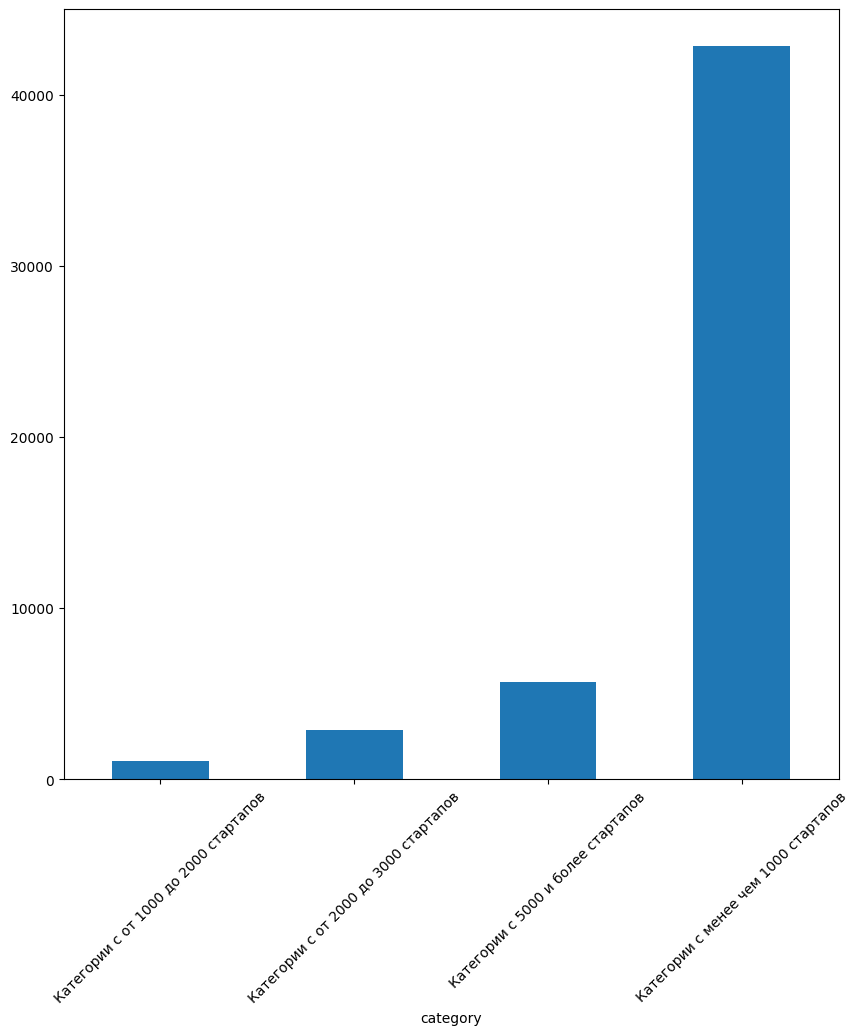

In [45]:
startups_train.groupby('category')['name'].count().sort_values().plot(kind='bar', figsize=(10, 10))
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Рассмотрим информацию о параметре 'country_code'
startups_train.groupby('country_code')['name'].count().sort_values()

**В ней 134 страны**

In [ ]:
def less_countries(country_code):
    if startups_train.loc[startups_train['country_code'] == country_code]['country_code'].count() < 7200:
        return 'Страны с менее чем 7200 стартапов'
    elif 7200 <= startups_train.loc[startups_train['country_code'] == country_code]['country_code'].count() < 14400:
        return 'Страны с от 7200 до 14400 стартапов'
    elif 14400 <= startups_train.loc[startups_train['country_code'] == country_code]['country_code'].count() < 21600:
        return 'Страны с от 14400 до 21600 стартапов'
    elif 21600 <= startups_train.loc[startups_train['country_code'] == country_code]['country_code'].count() < 28800:
        return 'Страны с от 21600 до 28800 стартапов'
    elif 28800 <= startups_train.loc[startups_train['country_code'] == country_code]['country_code'].count() < 36000:
        return 'Страны с от 28800 до 36000 стартапов'
    else:
        return 'Страны с 36000 и более стартапов'

In [ ]:
startups_train['countries'] = startups_train['country_code'].apply(less_countries)

<a id='models'></a>
## [Разработка моделей](#start)

In [ ]:
# Разделим датасет на датасеты с входными и целевым признаком
X_train = startups_train.drop(['name', 'status'], axis=1)
y_train = startups_train['status']
X_test = startups_test.drop(['name', 'status'], axis=1)
y_test = startups_test['status']
# Создаем класс для кодирования категориальных данных
encoder = OrdinalEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
# Создаем список категориальных признаков
cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
# Создаем список количественных признаков
num_col_names = X_train.select_dtypes(include='number').columns.tolist()
# Кодируем категориальные признаки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
# Сохраняем в переменной названия новых столбцов
encoder_col_names = encoder.get_feature_names_out()
# Создаем датафреймы из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
# Создаем класс для масштабирования количественных данных
scaler = StandardScaler()
# Масштабируем количественные данные
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
# Создаем датафреймы из масштабированных данных
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
# Объединяем преобразованные данные в тренировочный и тестовый датасеты
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
# Инициилизируем модель kNN
model = KNeighborsClassifier()
# Обучаем модель на тренировочных данных
model.fit(X_train, y_train)
# Получаем предсказания и сохраняем их в переменную
predictions = model.predict(X_test)
# Расчитываем roc_auc_score
score = roc_auc_score(y_test, predictions)

In [ ]:
score